# Packages

In [1]:
import sys
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
import sklearn.metrics
from sklearn.model_selection import train_test_split
import random
import cebra
from cebra import CEBRA
import cebra.grid_search
import time
import joblib as jl
from matplotlib.collections import LineCollection
import cebra.integrations.plotly
import os
import torch
import re
%matplotlib inline

In [2]:
output_dir = "/scratch/09117/xz6783/Xu/CEBRA/Cebra_behavior/Cat_odor_conflict/training/output_with_tone_active"
model_dir = "/scratch/09117/xz6783/Xu/CEBRA/Cebra_behavior/Cat_odor_conflict/visualization/models_with_tone"
source_dir = "/scratch/09117/xz6783/Xu/CEBRA/Cebra_behavior/Cat_odor_conflict/training/data_with_tone"


In [3]:
import matplotlib as mpl
plt.rcParams['font.family'] = 'Liberation Sans'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['text.color'] = 'k'
plt.rcParams['svg.fonttype'] = 'none'

# 1. Load embbedings

In [9]:
filenames = os.listdir(model_dir)

# Regular expression pattern to match number+letter+number before an underscore
pattern = r'\d{1,2}[A-Za-z]\d{1,2}'

# Extract and store animal IDs
animal_ids = [re.search(pattern, filename.split('_')[0]).group() for filename in filenames if re.search(pattern, filename.split('_')[0])]

# animal_ids = [re.search(pattern, filename.split('_')[0]).group() for filename in filenames if re.search(pattern, filename)]

len(animal_ids)

32

In [10]:
filenames = os.listdir(model_dir)
combid = 1
pattern = rf'cebra_behavior_model_comb{combid}_embedding (\d{{1,2}}[A-Za-z]\d{{1,2}})\.csv'

# List to hold matching filenames
matching_files = []
extracted_parts = []

# Loop through the filenames and check if they match the pattern
for filename in filenames:
    match = re.search(pattern, filename)
    if match:
        matching_files.append(filename)
        extracted_parts.append(match.group(1))
# Print or process the matching filenames
print("Matching files and their extracted parts:")
for file, part in zip(matching_files, extracted_parts):
    print(f"{file} -> {part}")

Matching files and their extracted parts:
cebra_behavior_model_comb1_embedding 2Z4.csv -> 2Z4
cebra_behavior_model_comb1_embedding 2I5.csv -> 2I5
cebra_behavior_model_comb1_embedding 6H6.csv -> 6H6
cebra_behavior_model_comb1_embedding 6S5.csv -> 6S5
cebra_behavior_model_comb1_embedding 1S5.csv -> 1S5
cebra_behavior_model_comb1_embedding 2N6.csv -> 2N6
cebra_behavior_model_comb1_embedding 9M6.csv -> 9M6
cebra_behavior_model_comb1_embedding 6M6.csv -> 6M6


In [11]:
def load_embedding(model_dir, combid):
    beddings = {}
    csv_files = [file for file in os.listdir(model_dir) if file.endswith('.csv')]

    for csv_file in csv_files:
        file_path = os.path.join(model_dir, csv_file)
        
        # Extract animal ID from filename
        pattern = rf'cebra_behavior_model_comb{combid}_embedding (\d{{1,2}}[A-Za-z]\d{{1,2}})\.csv'
        match = re.search(pattern, csv_file)
        if match:
            animal_id = match.group(1)
            try:
                fileData = np.loadtxt(file_path, delimiter=',')
                beddings[animal_id] = fileData
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

    return beddings

def load_shuffle_embedding(model_dir, combid):
    beddings = {}
    csv_files = [file for file in os.listdir(model_dir) if file.endswith('.csv')]

    for csv_file in csv_files:
        file_path = os.path.join(model_dir, csv_file)
        
        # Extract animal ID from filename
        pattern = rf'cebra_behavior_model_comb{combid}_embedding_shuffled (\d{{1,2}}[A-Za-z]\d{{1,2}})\.csv'
        match = re.search(pattern, csv_file)
        if match:
            animal_id = match.group(1)
            try:
                fileData = np.loadtxt(file_path, delimiter=',')
                beddings[animal_id] = fileData
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

    return beddings

def load_embedding(model_dir, combid):
    beddings = {}
    csv_files = [file for file in os.listdir(model_dir) if file.endswith('.csv')]

    for csv_file in csv_files:
        file_path = os.path.join(model_dir, csv_file)
        
        # Extract animal ID from filename
        pattern = rf'cebra_behavior_model_comb{combid}_embedding (\d{{1,2}}[A-Za-z]\d{{1,2}})\.csv'
        match = re.search(pattern, csv_file)
        if match:
            animal_id = match.group(1)
            try:
                fileData = np.loadtxt(file_path, delimiter=',')
                beddings[animal_id] = fileData
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

    return beddings

def load_labels(source_dir, animal_ids):
    labels_train = []
    labels_test = []
    
    for animal_id in animal_ids:
        Dt = pd.read_csv(os.path.join(source_dir, f'{animal_id}.csv'), index_col= 0)
        Y = Dt.iloc[:, 0:9]
        X = Dt.iloc[:, 9:]
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 2024)

        labels_train.append(y_train)
        labels_test.append(y_test)
    
    return labels_train, labels_test

In [12]:
beddings_comb1 = load_embedding(model_dir, combid = '1')
beddings_comb2 = load_embedding(model_dir, combid = '2')
beddings_comb3 = load_embedding(model_dir, combid = '3')
beddings_comb4 = load_embedding(model_dir, combid = '4')
beddings_comb1_shuffled = load_shuffle_embedding(model_dir, 1)
beddings_comb2_shuffled = load_shuffle_embedding(model_dir, 2)
beddings_comb3_shuffled = load_shuffle_embedding(model_dir, 3)
beddings_comb4_shuffled = load_shuffle_embedding(model_dir, 4)

In [13]:
beddings_comb1.keys()

dict_keys(['2Z4', '2I5', '6H6', '6S5', '1S5', '2N6', '9M6', '6M6'])

In [14]:
animal_ids_reordered = ['2Z4','2I5', '9M6', '6M6', '2N6', '1S5', '6S5', '6H6']
beddings_comb1 = {animal_id: beddings_comb1[animal_id] for animal_id in animal_ids_reordered if animal_id in beddings_comb1}
beddings_comb2 = {animal_id: beddings_comb2[animal_id] for animal_id in animal_ids_reordered if animal_id in beddings_comb2}
beddings_comb3 = {animal_id: beddings_comb3[animal_id] for animal_id in animal_ids_reordered if animal_id in beddings_comb3}
beddings_comb4 = {animal_id: beddings_comb4[animal_id] for animal_id in animal_ids_reordered if animal_id in beddings_comb4}
beddings_comb1_shuffled = {animal_id: beddings_comb1_shuffled[animal_id] for animal_id in animal_ids_reordered if animal_id in beddings_comb1_shuffled}
beddings_comb2_shuffled = {animal_id: beddings_comb2_shuffled[animal_id] for animal_id in animal_ids_reordered if animal_id in beddings_comb2_shuffled}
beddings_comb3_shuffled = {animal_id: beddings_comb3_shuffled[animal_id] for animal_id in animal_ids_reordered if animal_id in beddings_comb3_shuffled}
beddings_comb4_shuffled = {animal_id: beddings_comb4_shuffled[animal_id] for animal_id in animal_ids_reordered if animal_id in beddings_comb4_shuffled}

In [15]:
labels_train, labels_test = load_labels(source_dir, animal_ids_reordered)

In [16]:
labels_train

[      Timepoint        Time     Speed  Freezing  In Food Area  In Hidden Area  \
 43           44    44.03325  0.007170       0.0      1.000000             0.0   
 962         963   974.55210  0.010619       0.0      0.000000             0.0   
 857         858   868.22605  0.020590       0.0      0.941667             0.0   
 1165       1166  1180.12005  0.040624       0.0      0.311873             0.0   
 491         492   497.62770  0.055164       0.0      0.997222             0.0   
 ...         ...         ...       ...       ...           ...             ...   
 539         540   546.26120  0.003672       0.0      0.000000             0.0   
 640         641   648.53855  0.001841       0.0      0.000000             1.0   
 608         609   616.09955  0.018535       0.0      0.000000             1.0   
 1530       1531  1549.70560  0.010674       0.0      1.000000             0.0   
 1672       1673  1693.48520  0.042177       0.0      0.000000             1.0   
 
       Bar Pre

# 2. Consistency

## (1). Freezing+Hidden area

In [ ]:
labels_train_comb1 = [label.iloc[:,5].values for label in labels_train]

In [ ]:
embeddings_comb1 = list(beddings_comb1.values())

In [ ]:
scores, pairs, subjects = cebra.sklearn.metrics.consistency_score(embeddings=embeddings_comb1,
                                                                                 labels=labels_train_comb1,
                                                                                 dataset_ids=animal_ids_reordered,
                                                                                  between="datasets",
                                                                                 num_discretization_bins= 6)
cebra.plot_consistency(scores, pairs=pairs, datasets=animal_ids_reordered,
                             title="Comb1", colorbar_label=None)

In [271]:
avg_scores = {}
for score, pair in zip(scores, pairs):
    key = f"{sorted(pair)[0]}-{sorted(pair)[1]}"
    if key in avg_scores.keys():
        avg_scores[key].append(score)
    else:
        avg_scores[key] = [score]

for key in avg_scores.keys():
    avg_scores[key] = sum(avg_scores[key]) / len(avg_scores[key])

print(np.array(list(avg_scores.values())))

[0.80283667 0.7887932  0.61121417 0.79582069 0.51180768 0.7352985
 0.71116825 0.88095815 0.71868824 0.75767378 0.6466191  0.74564637
 0.80718471 0.74364334 0.75261104 0.80244023 0.73637166 0.86845562
 0.89547232 0.84605662 0.89806315 0.85646671 0.80309144 0.97205142
 0.59871281 0.80999144 0.72365119 0.63691887]


In [272]:
avg_scores

{'2I5-2Z4': 0.8028366681489574,
 '2Z4-9M6': 0.7887932001245685,
 '2Z4-6M6': 0.6112141672614975,
 '2N6-2Z4': 0.7958206924240536,
 '1S5-2Z4': 0.5118076847070846,
 '2Z4-6S5': 0.7352984962366199,
 '2Z4-6H6': 0.7111682452214958,
 '2I5-9M6': 0.8809581544821604,
 '2I5-6M6': 0.7186882436552373,
 '2I5-2N6': 0.7576737829013265,
 '1S5-2I5': 0.6466190957361682,
 '2I5-6S5': 0.7456463682306884,
 '2I5-6H6': 0.8071847096386908,
 '6M6-9M6': 0.7436433415077053,
 '2N6-9M6': 0.7526110422610155,
 '1S5-9M6': 0.8024402318741641,
 '6S5-9M6': 0.7363716644935908,
 '6H6-9M6': 0.8684556224602749,
 '2N6-6M6': 0.8954723214763978,
 '1S5-6M6': 0.8460566241262966,
 '6M6-6S5': 0.8980631469746154,
 '6H6-6M6': 0.8564667090366982,
 '1S5-2N6': 0.8030914373201528,
 '2N6-6S5': 0.9720514156421363,
 '2N6-6H6': 0.5987128110175945,
 '1S5-6S5': 0.8099914352118003,
 '1S5-6H6': 0.72365119485654,
 '6H6-6S5': 0.6369188664724665}

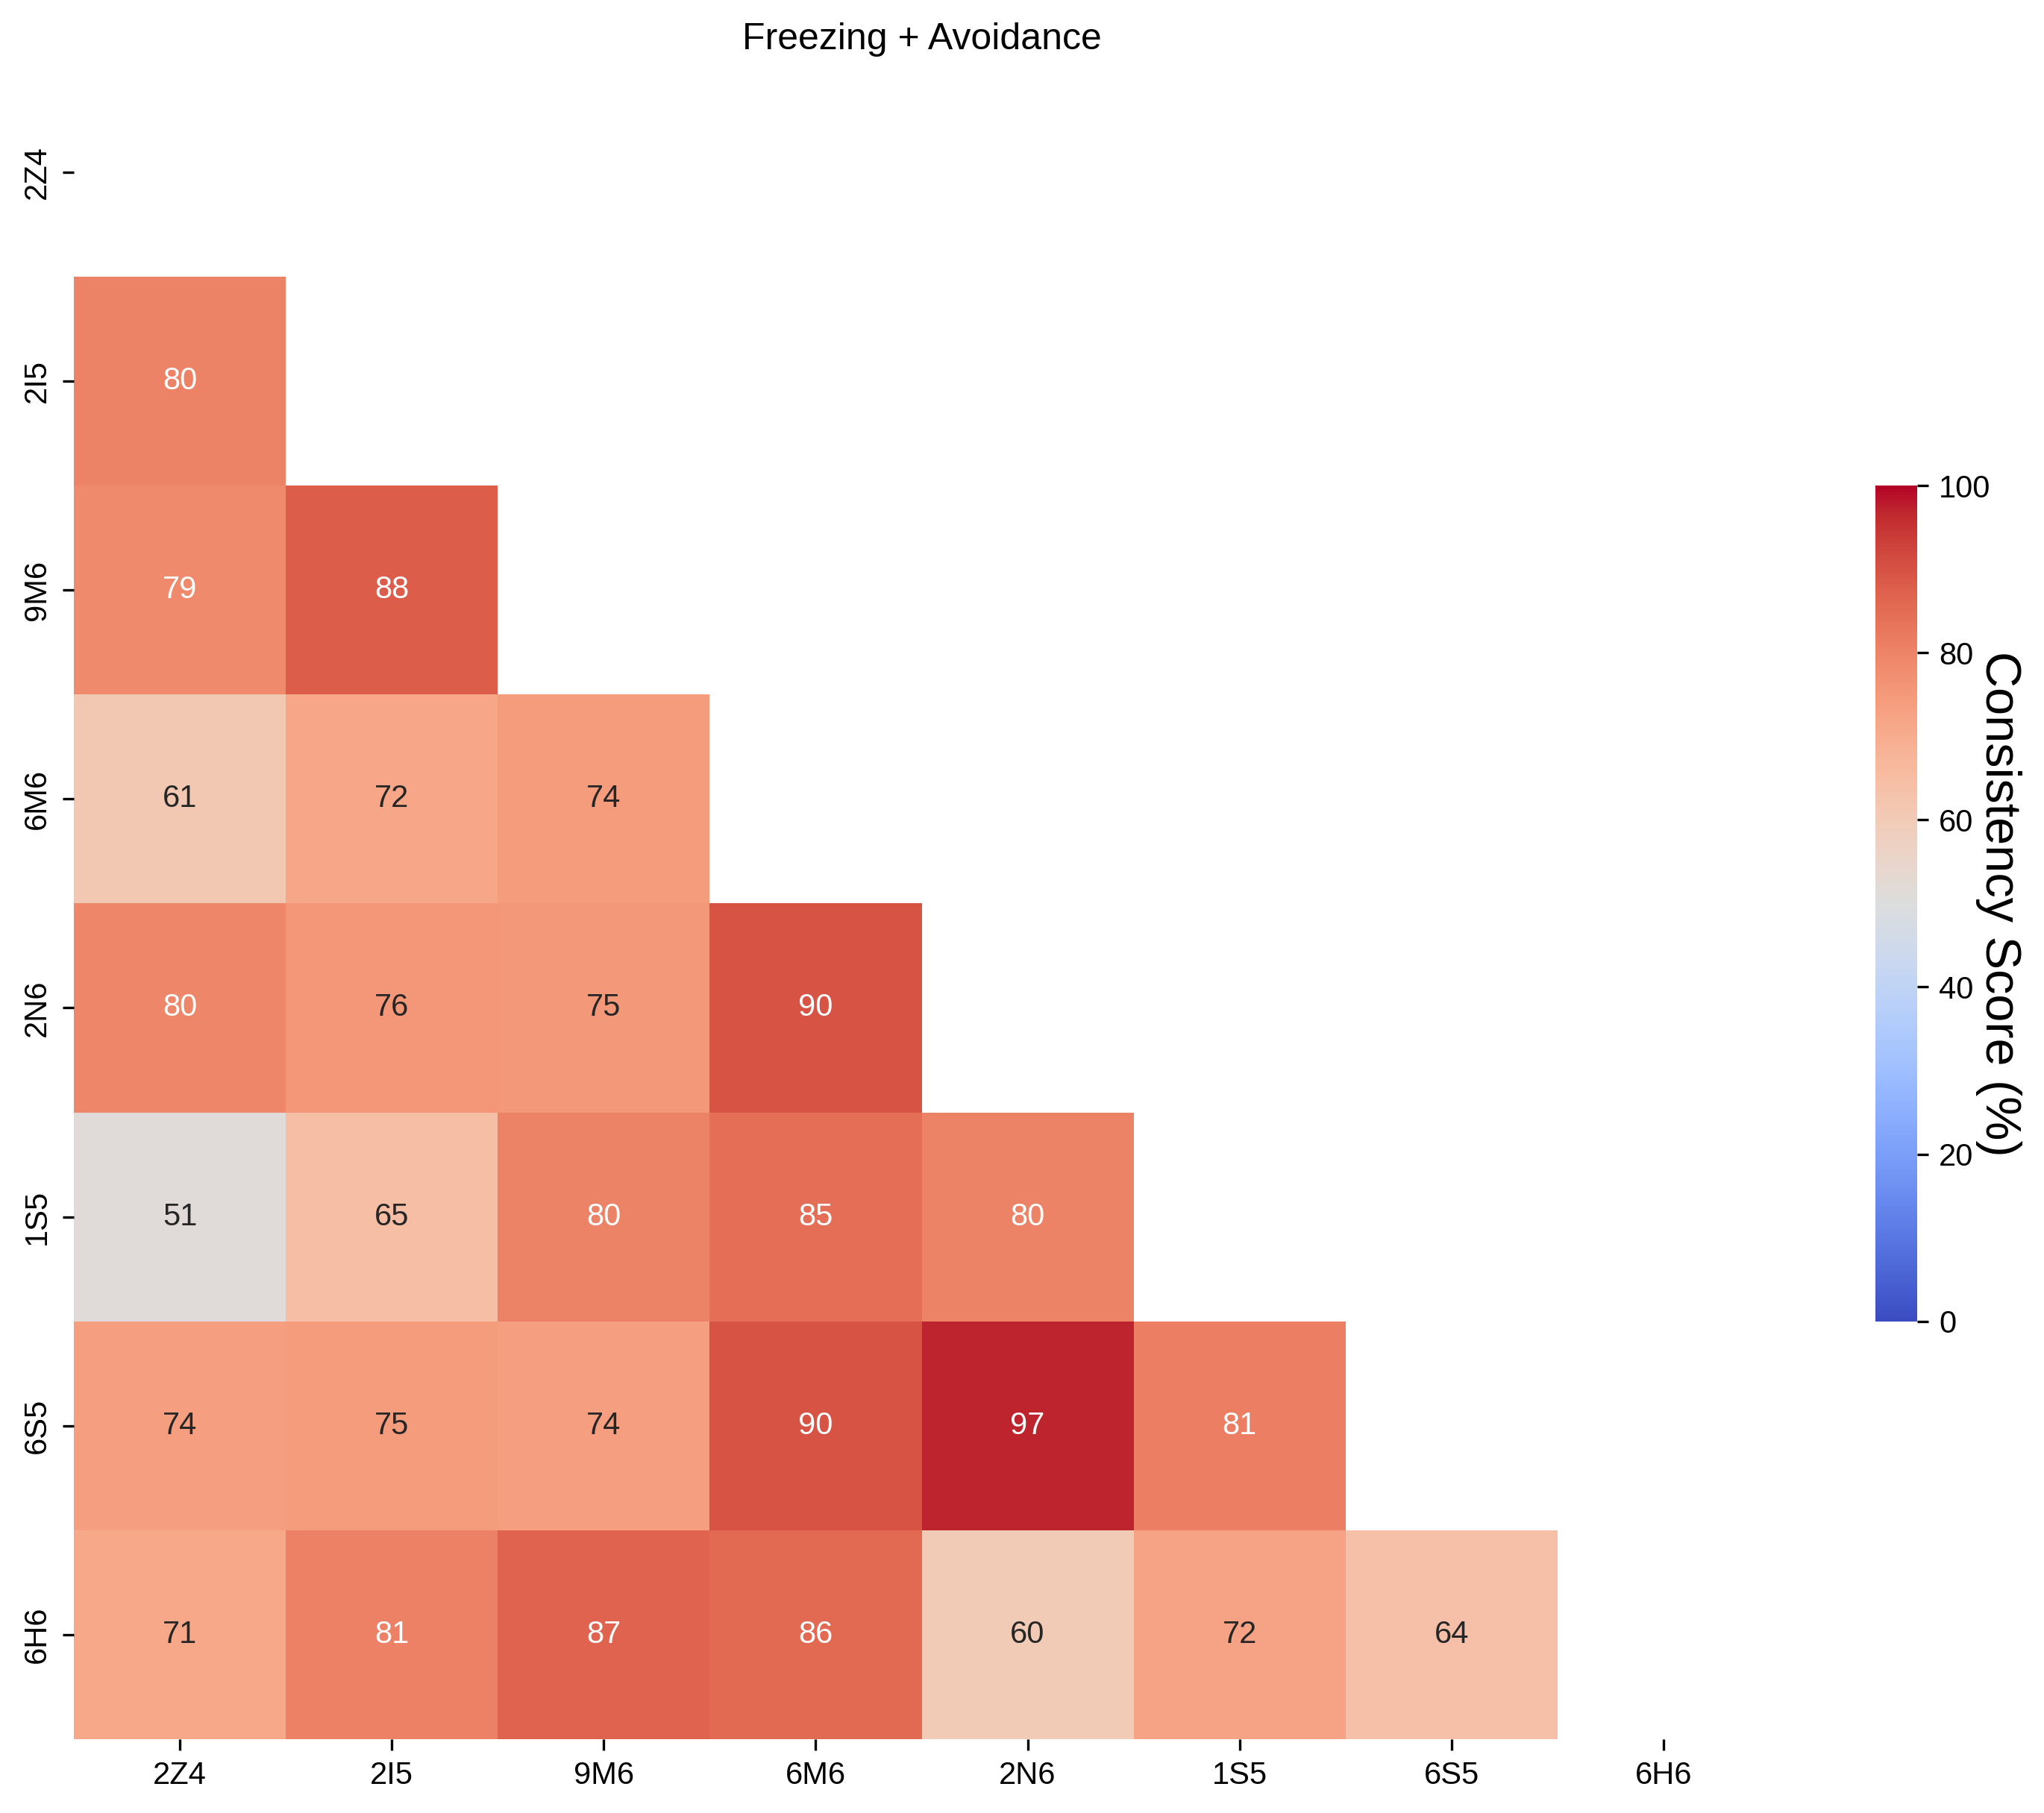

In [282]:
# Extract unique labels
labels = set()
for key in avg_scores.keys():
    labels.update(key.split('-'))
labels = sorted(labels)

# Create an empty DataFrame
matrix = pd.DataFrame(index=animal_ids_reordered, columns=animal_ids_reordered, data=np.nan)

# Fill the DataFrame with the average scores
for key, value in avg_scores.items():
    item1, item2 = key.split('-')
    matrix.loc[item1, item2] = value*100
    matrix.loc[item2, item1] = value*100  # Ensure symmetry

# Create a mask to leave the diagonal and the upper triangle blank
mask = np.triu(np.ones_like(matrix, dtype=bool))

# Plot the heatmap
fig, ax = plt.subplots(figsize=(10, 8), dpi = 300)
sns.heatmap(matrix, annot=True, cmap='coolwarm', mask=mask, vmin = 0, vmax = 100, cbar_kws={"shrink": .5}, ax = ax)
cbar = ax.collections[0].colorbar
cbar.set_label('Consistency Score (%)', rotation=270, labelpad=10, fontsize = 16)
plt.tight_layout()

plt.title('Freezing + Avoidance')
plt.show()

## (2). Approach + Lever

In [283]:
labels_train_comb2 = [label.iloc[:,4].values for label in labels_train]

In [284]:
embeddings_comb2 = list(beddings_comb2.values())

<AxesSubplot:title={'center':'Comb1'}>

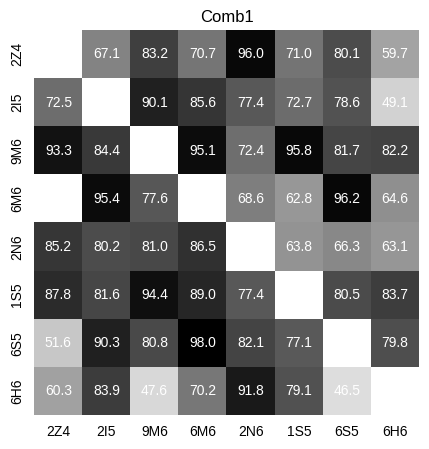

In [285]:
scores, pairs, subjects = cebra.sklearn.metrics.consistency_score(embeddings=embeddings_comb2,
                                                                                 labels=labels_train_comb2,
                                                                                 dataset_ids=animal_ids_reordered,
                                                                                  between="datasets",
                                                                                 num_discretization_bins= 6)
cebra.plot_consistency(scores, pairs=pairs, datasets=animal_ids_reordered,
                             title="Comb1", colorbar_label=None)

In [286]:
avg_scores = {}
for score, pair in zip(scores, pairs):
    key = f"{sorted(pair)[0]}-{sorted(pair)[1]}"
    if key in avg_scores.keys():
        avg_scores[key].append(score)
    else:
        avg_scores[key] = [score]

for key in avg_scores.keys():
    avg_scores[key] = sum(avg_scores[key]) / len(avg_scores[key])

print(np.array(list(avg_scores.values())))

[0.69769741 0.88273775 0.54605989 0.90592985 0.79389286 0.65847753
 0.6003676  0.87248303 0.90499032 0.78814292 0.77143095 0.84461414
 0.66480827 0.86345737 0.76707934 0.95086801 0.81281178 0.64946096
 0.77534117 0.75916105 0.97087836 0.67409602 0.70563854 0.74222029
 0.77421756 0.78773971 0.8138031  0.63147635]


In [287]:
avg_scores

{'2I5-2Z4': 0.6976974097384173,
 '2Z4-9M6': 0.8827377457986234,
 '2Z4-6M6': 0.5460598896497699,
 '2N6-2Z4': 0.9059298515071047,
 '1S5-2Z4': 0.7938928550142481,
 '2Z4-6S5': 0.6584775342328477,
 '2Z4-6H6': 0.6003675962393669,
 '2I5-9M6': 0.8724830282567801,
 '2I5-6M6': 0.9049903224398255,
 '2I5-2N6': 0.7881429215388707,
 '1S5-2I5': 0.7714309518639311,
 '2I5-6S5': 0.844614143009736,
 '2I5-6H6': 0.6648082688562986,
 '6M6-9M6': 0.8634573698579897,
 '2N6-9M6': 0.7670793427448386,
 '1S5-9M6': 0.950868010285566,
 '6S5-9M6': 0.8128117819728644,
 '6H6-9M6': 0.6494609621881223,
 '2N6-6M6': 0.7753411687080929,
 '1S5-6M6': 0.7591610547496654,
 '6M6-6S5': 0.9708783573717323,
 '6H6-6M6': 0.6740960222198131,
 '1S5-2N6': 0.705638540521552,
 '2N6-6S5': 0.7422202938968482,
 '2N6-6H6': 0.7742175585823714,
 '1S5-6S5': 0.7877397059320714,
 '1S5-6H6': 0.8138031025971935,
 '6H6-6S5': 0.631476347541987}

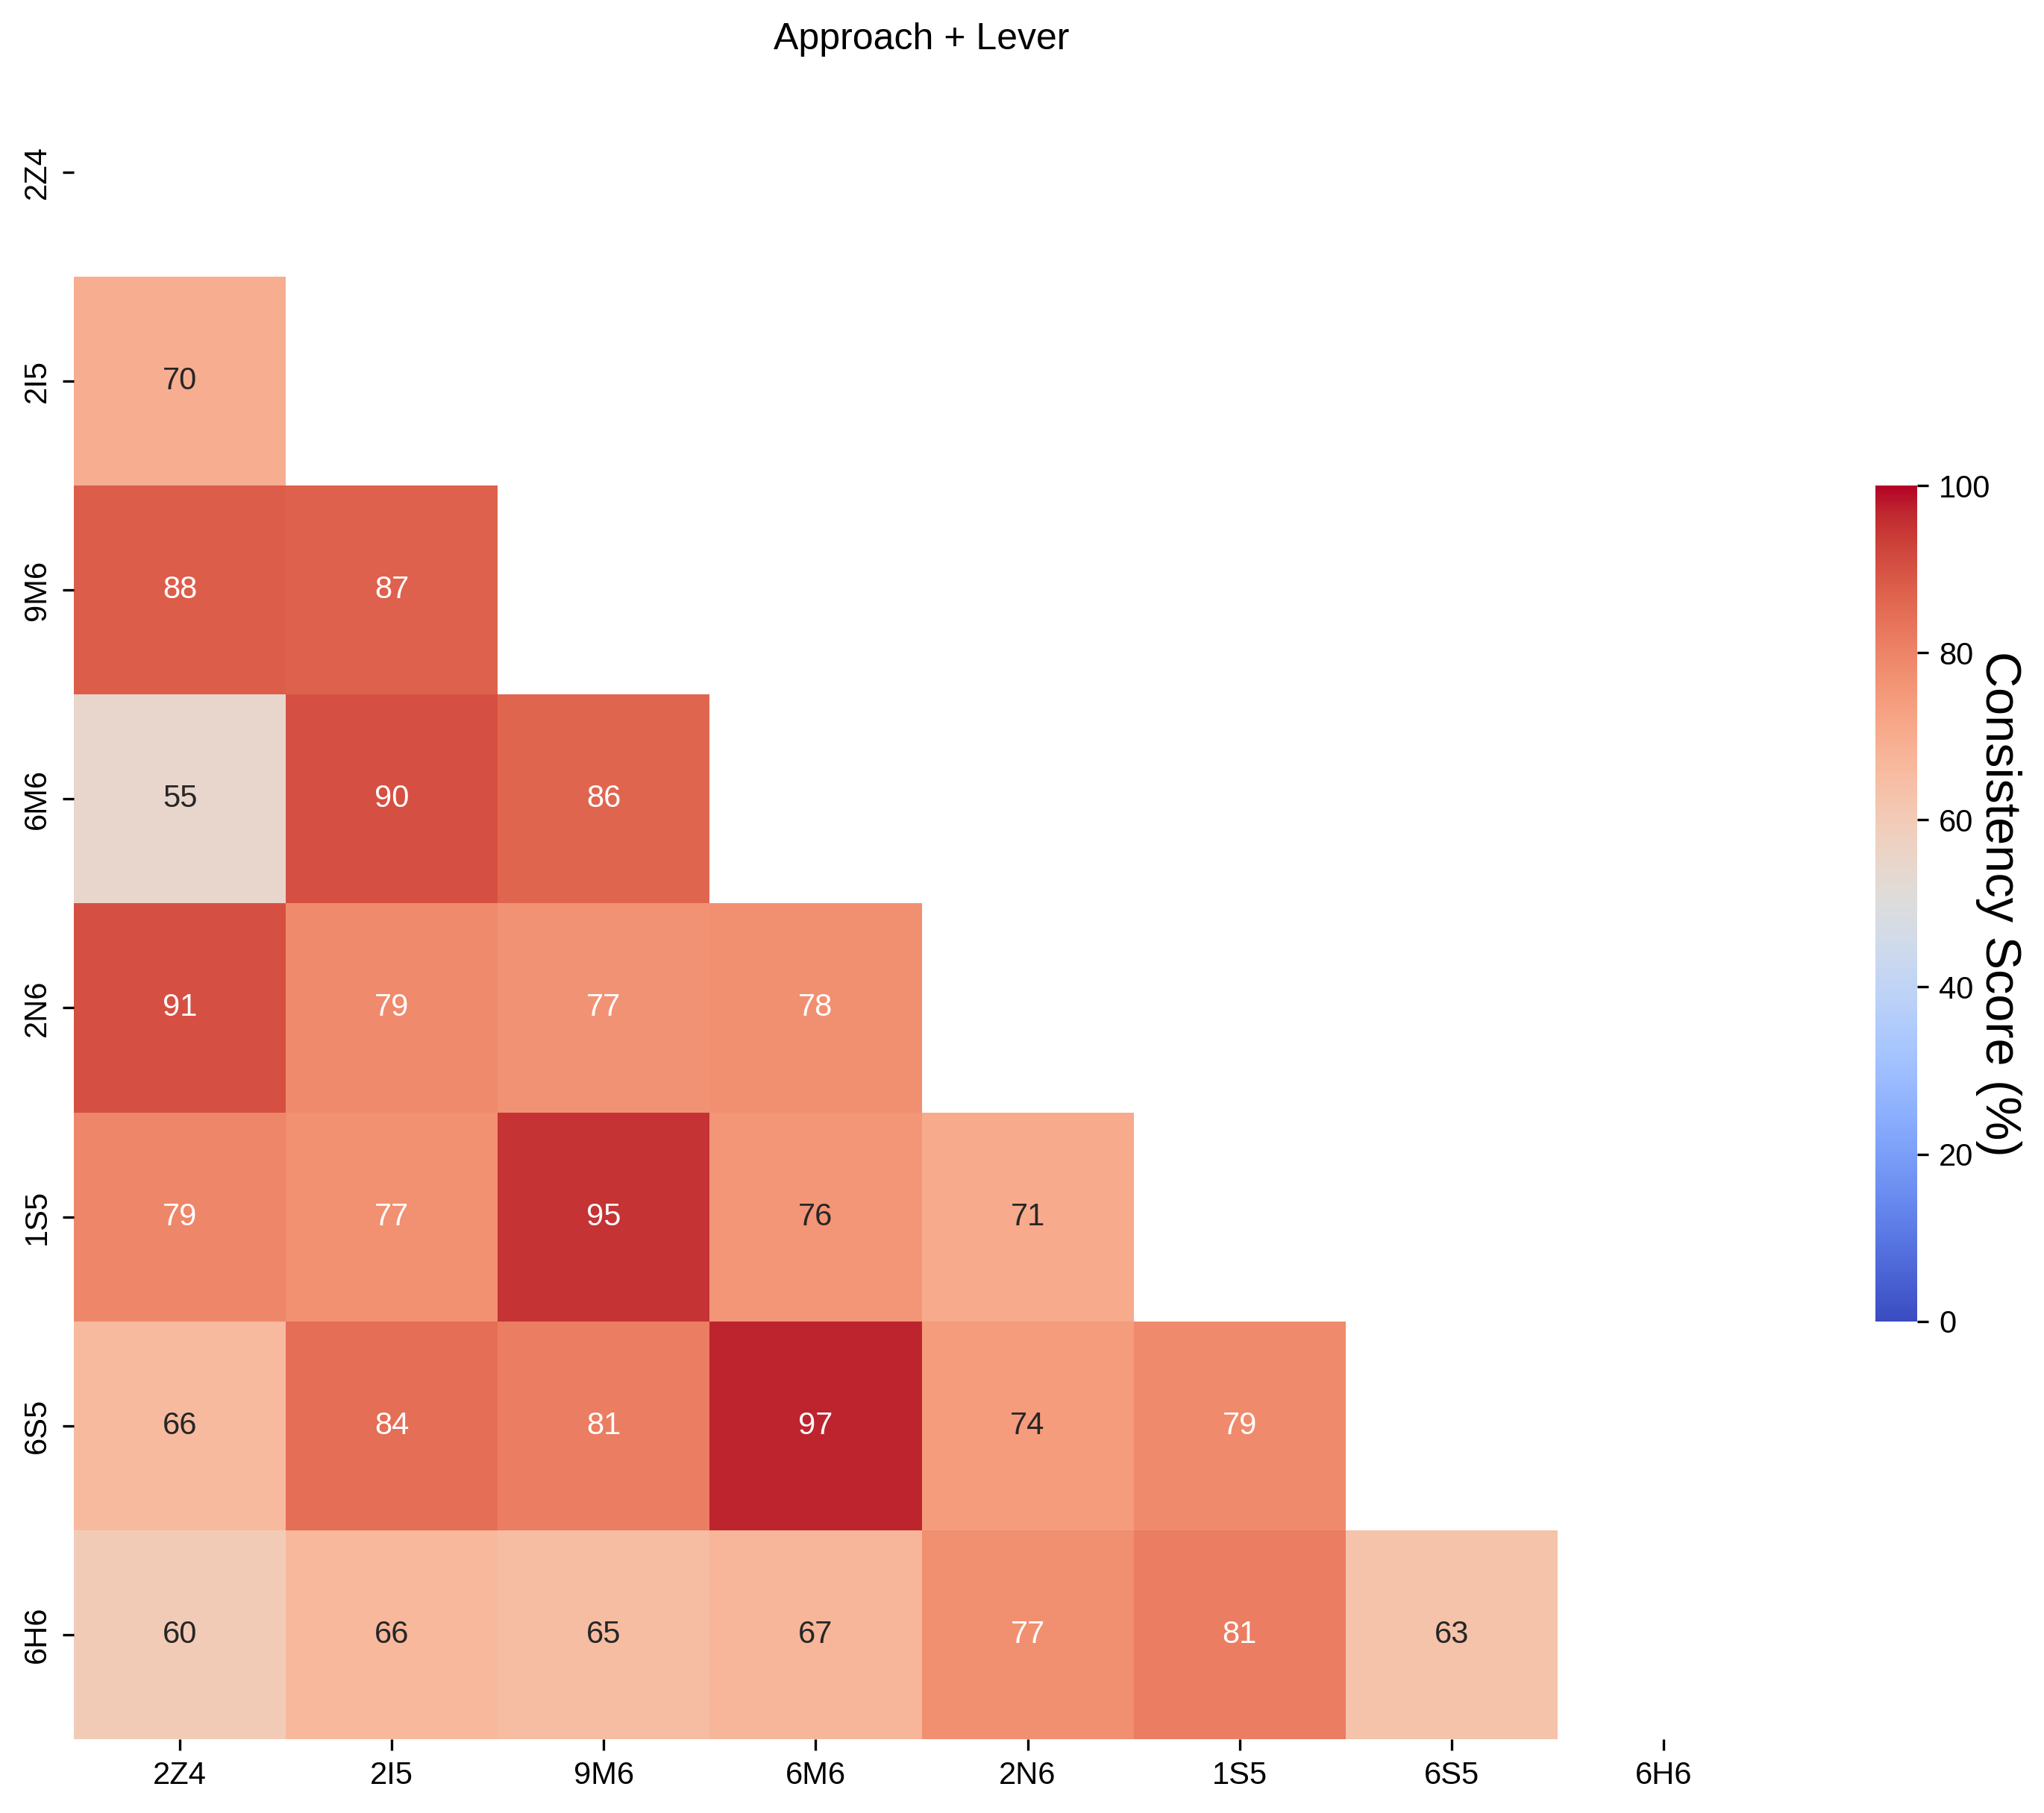

In [288]:
# Extract unique labels
labels = set()
for key in avg_scores.keys():
    labels.update(key.split('-'))
labels = sorted(labels)

# Create an empty DataFrame
matrix = pd.DataFrame(index=animal_ids_reordered, columns=animal_ids_reordered, data=np.nan)

# Fill the DataFrame with the average scores
for key, value in avg_scores.items():
    item1, item2 = key.split('-')
    matrix.loc[item1, item2] = value*100
    matrix.loc[item2, item1] = value*100  # Ensure symmetry

# Create a mask to leave the diagonal and the upper triangle blank
mask = np.triu(np.ones_like(matrix, dtype=bool))

# Plot the heatmap
fig, ax = plt.subplots(figsize=(10, 8), dpi = 300)
sns.heatmap(matrix, annot=True, cmap='coolwarm', mask=mask, vmin = 0, vmax = 100, cbar_kws={"shrink": .5}, ax = ax)
cbar = ax.collections[0].colorbar
cbar.set_label('Consistency Score (%)', rotation=270, labelpad=10, fontsize = 16)
plt.tight_layout()

plt.title('Approach + Lever')
plt.show()

## (3). Tone

In [289]:
labels_train_comb3 = [label.iloc[:,8].values for label in labels_train]

In [290]:
embeddings_comb3 = list(beddings_comb3.values())

<AxesSubplot:title={'center':'Comb1'}>

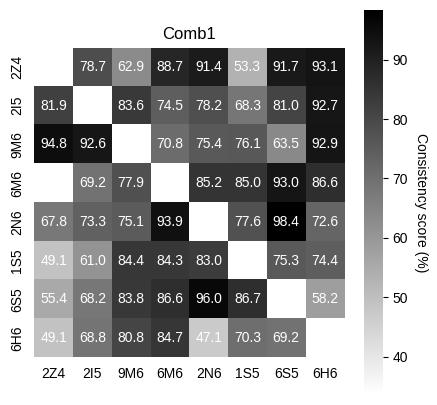

In [291]:
scores, pairs, subjects = cebra.sklearn.metrics.consistency_score(embeddings=embeddings_comb3,
                                                                                 labels=labels_train_comb3,
                                                                                 dataset_ids=animal_ids_reordered,
                                                                                  between="datasets",
                                                                                  num_discretization_bins=6
                                                                                 )
cebra.plot_consistency(scores, pairs=pairs, datasets=animal_ids_reordered, cmap = 'binary',
                             title="Comb1", colorbar_label='Consistency score (%)')

In [292]:
avg_scores = {}
for score, pair in zip(scores, pairs):
    key = f"{sorted(pair)[0]}-{sorted(pair)[1]}"
    if key in avg_scores.keys():
        avg_scores[key].append(score)
    else:
        avg_scores[key] = [score]

for key in avg_scores.keys():
    avg_scores[key] = sum(avg_scores[key]) / len(avg_scores[key])

print(np.array(list(avg_scores.values())))

[0.80283667 0.7887932  0.61121417 0.79582069 0.51180768 0.7352985
 0.71116825 0.88095815 0.71868824 0.75767378 0.6466191  0.74564637
 0.80718471 0.74364334 0.75261104 0.80244023 0.73637166 0.86845562
 0.89547232 0.84605662 0.89806315 0.85646671 0.80309144 0.97205142
 0.59871281 0.80999144 0.72365119 0.63691887]


In [293]:
avg_scores

{'2I5-2Z4': 0.8028366681489574,
 '2Z4-9M6': 0.7887932001245685,
 '2Z4-6M6': 0.6112141672614975,
 '2N6-2Z4': 0.7958206924240536,
 '1S5-2Z4': 0.5118076847070846,
 '2Z4-6S5': 0.7352984962366199,
 '2Z4-6H6': 0.7111682452214958,
 '2I5-9M6': 0.8809581544821604,
 '2I5-6M6': 0.7186882436552373,
 '2I5-2N6': 0.7576737829013265,
 '1S5-2I5': 0.6466190957361682,
 '2I5-6S5': 0.7456463682306884,
 '2I5-6H6': 0.8071847096386908,
 '6M6-9M6': 0.7436433415077053,
 '2N6-9M6': 0.7526110422610155,
 '1S5-9M6': 0.8024402318741641,
 '6S5-9M6': 0.7363716644935908,
 '6H6-9M6': 0.8684556224602749,
 '2N6-6M6': 0.8954723214763978,
 '1S5-6M6': 0.8460566241262966,
 '6M6-6S5': 0.8980631469746154,
 '6H6-6M6': 0.8564667090366982,
 '1S5-2N6': 0.8030914373201528,
 '2N6-6S5': 0.9720514156421363,
 '2N6-6H6': 0.5987128110175945,
 '1S5-6S5': 0.8099914352118003,
 '1S5-6H6': 0.72365119485654,
 '6H6-6S5': 0.6369188664724665}

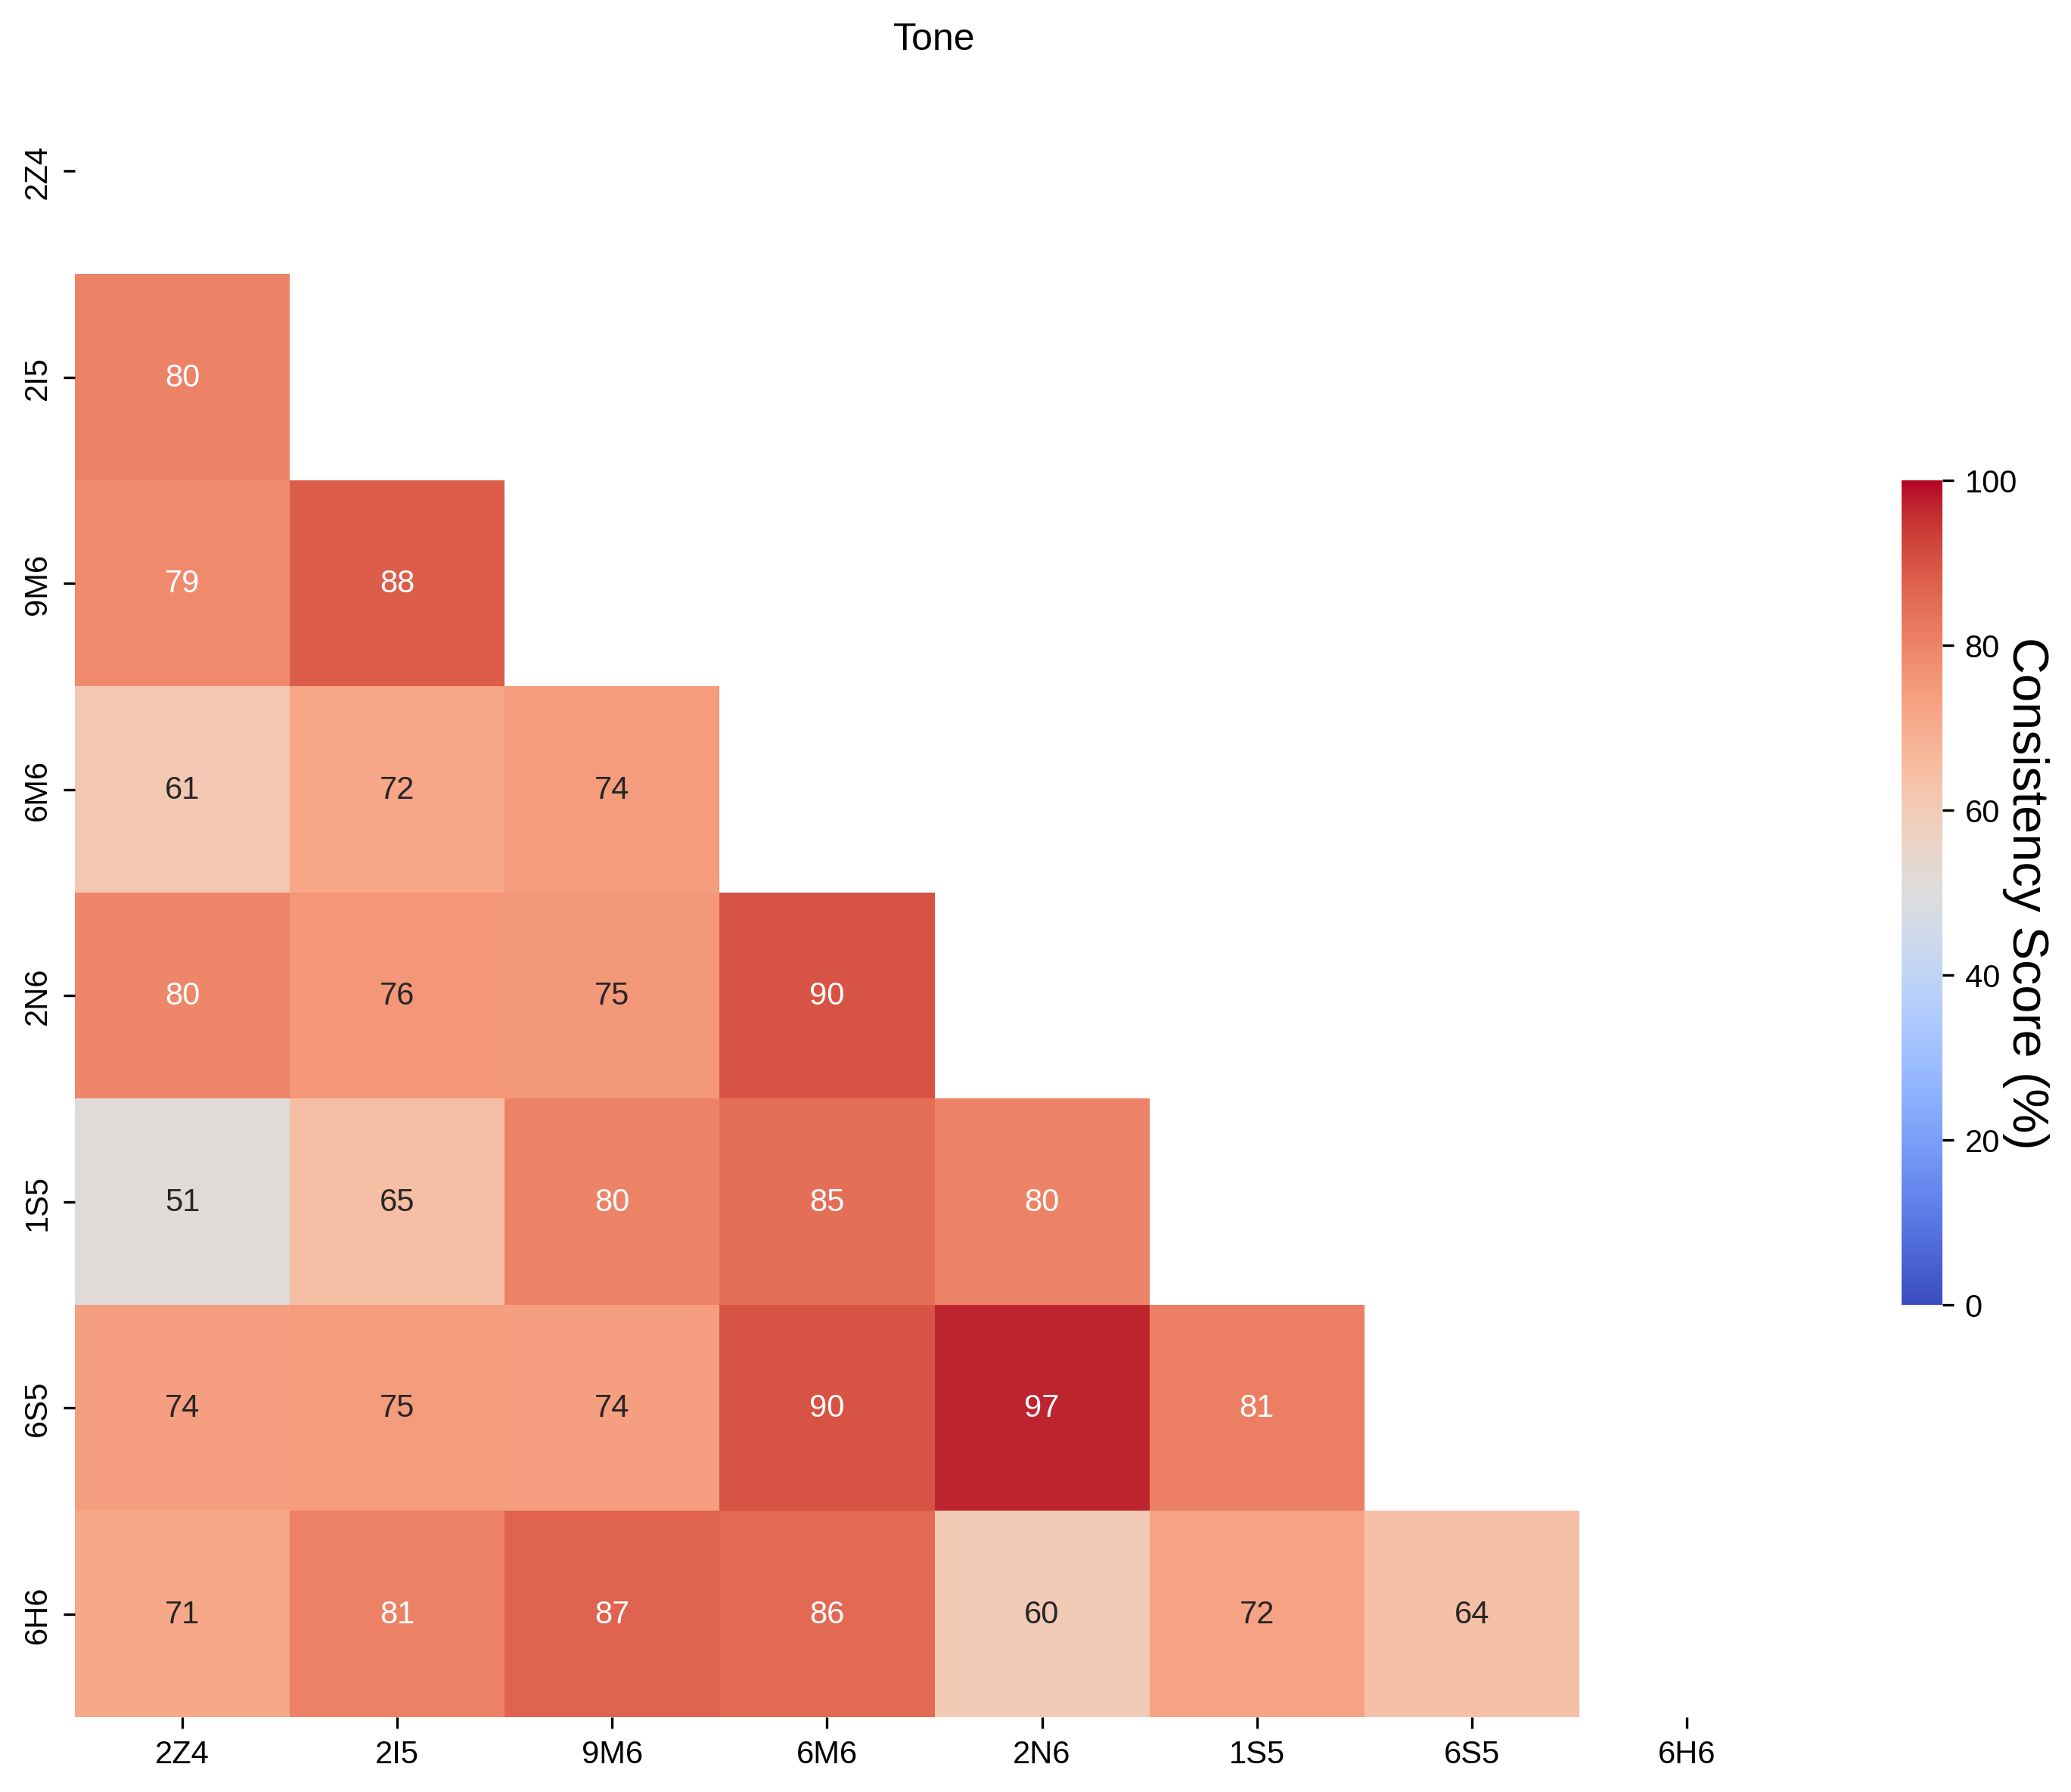

In [297]:
# Extract unique labels
labels = set()
for key in avg_scores.keys():
    labels.update(key.split('-'))
labels = sorted(labels)

# Create an empty DataFrame
matrix = pd.DataFrame(index=animal_ids_reordered, columns=animal_ids_reordered, data=np.nan)

# Fill the DataFrame with the average scores
for key, value in avg_scores.items():
    item1, item2 = key.split('-')
    matrix.loc[item1, item2] = value*100
    matrix.loc[item2, item1] = value*100  # Ensure symmetry

# Create a mask to leave the diagonal and the upper triangle blank
mask = np.triu(np.ones_like(matrix, dtype=bool))

# Plot the heatmap
fig, ax = plt.subplots(figsize=(10, 8), dpi = 300)
sns.heatmap(matrix, annot=True, cmap='coolwarm', mask=mask, vmin = 0, vmax = 100, cbar_kws={"shrink": .5}, ax = ax)
cbar = ax.collections[0].colorbar
cbar.set_label('Consistency Score (%)', rotation=270, labelpad=10, fontsize = 16)
plt.title('Tone')
plt.tight_layout()

plt.savefig("/scratch/09117/xz6783/Xu/Plots/Fig2/fig2_consistency_heatmap_cat_odor.svg", transparent=True, bbox_inches = 'tight')

plt.show()

In [269]:
labels_train_comb3 = [label.iloc[:,8].values for label in labels_train]

In [270]:
embeddings_comb3_shuffled = list(beddings_comb3_shuffled.values())

<AxesSubplot:title={'center':'Comb1'}>

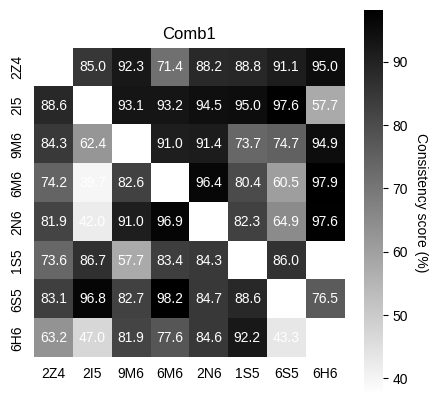

In [245]:
scores, pairs, subjects = cebra.sklearn.metrics.consistency_score(embeddings=embeddings_comb3_shuffled,
                                                                                 labels=labels_train_comb3,
                                                                                 dataset_ids=animal_ids_reordered,
                                                                                  between="datasets",
                                                                                  num_discretization_bins=6
                                                                                 )
cebra.plot_consistency(scores, pairs=pairs, datasets=animal_ids_reordered, cmap = 'binary',
                             title="Comb1", colorbar_label='Consistency score (%)')

In [230]:
embeddings_comb3_and_shuffled = list(beddings_comb3_shuffled.values()).extend(beddings_comb3.values())

In [ ]:
scores, pairs, subjects = cebra.sklearn.metrics.consistency_score(embeddings=embeddings_comb3_and_shuffled,
                                                                                 labels=labels_train_comb3,
                                                                                 dataset_ids=animal_ids_reordered,
                                                                                  between="datasets",
                                                                                  num_discretization_bins=6
                                                                                 )
cebra.plot_consistency(scores, pairs=pairs, datasets=animal_ids_reordered, cmap = 'binary',
                             title="Comb1", colorbar_label='Consistency score (%)')